# LSTM model testing

Here we have tested the LSTM model which was trained on cluster 1 (with x coordinate 8678). We used the data of cluster 2 (with x coordinate 9061) to predict the value of the density at 5th second from the given sequence of 60 density values

In [1]:
import numpy as np

import random

import matplotlib.pyplot as plt

import pandas as pd

from collections import deque

import time
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

#from tensorflow.keras.callbacks import ModelCheckpoint


from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
import math

from tensorflow.keras.models import load_model


def compare(Mat1,Mat2,per1,per2):

    total = len(Mat1)  # get the times

    num1 = int((per1/100)*total)

    num2 = int((per2/100)*total)

    plt.plot(range(num2-num1),Mat1[num1:num2],label="Prediction")

    plt.plot(range(num2-num1),Mat2[num1:num2],label="Actual")

    plt.legend()

    plt.show()


# below functions are used to preprocess data and to make it
# feasible so as to give it as input to the LSTM model

    
def preprocess_df(df):

    df.dropna(inplace=True)  

    return df




def preprocess_df_final(df):

    sequential_data = []  

    prev_days = deque(maxlen=SEQ_LEN) 
    

    for i in df.values:  

        prev_days.append(i[1])  

        if len(prev_days) == SEQ_LEN:  
            sequential_data.append([i[0],np.array(prev_days), i[-1]])  
    random.shuffle(sequential_data) 

    X = []

    y = []
     

    for time , seq, target in sequential_data:  
        X.append(seq)  
        y.append(target)  

    X=np.array(X)

    X=X.reshape((X.shape[0],X.shape[1],1))

    return X, y

Here attributes of the model are defined. (sequence length of 60 and prediction of the 5th sec)

In [14]:
MODEL =5
SEQ_LEN = 60
FUTURE_PERIOD_PREDICT = 5
EPOCHS = 10
SCALE = 1
BATCH_SIZE = 64
NAME = f"NEW-5-MODEL-60-SEQ-5-PRED-1-SCALE-128-64-32-32-8-1-1585210883"
index=["Time","Density"]
scaler = MinMaxScaler(feature_range=(0, 1))

main_df = pd.read_csv("df_9061.csv") 

main_df = main_df[['Timestep','Density']]

Scaling the input feature

In [15]:
main_df.columns=index

a1=np.array(main_df)

if SCALE==1:

    main_df["Density"] = scaler.fit_transform(main_df[["Density"]])

    
main_df

,Time,Density
0,0,0.00000
1,1,0.02381
2,2,0.02381
3,3,0.02381
4,4,0.02381
...,...,...
26219,26219,0.00000
26220,26220,0.00000
26221,26221,0.00000
26222,26222,0.00000


Shift the density value to get the actual value of density after 5 seconds

In [16]:
main_df=preprocess_df(main_df)
main_df['future'] = main_df["Density"].shift(-FUTURE_PERIOD_PREDICT)



In [17]:
times = sorted(main_df.index.values)  

len(times)

26224

Divide the data into train and validation

In [18]:
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]  

last_5pct

24913

In [19]:
validation_main_df = main_df[(main_df.index >= last_5pct)]  

main_df = main_df[(main_df.index < last_5pct)] 



In [20]:
validation_main_df.dropna(inplace=True)



/home/sahil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
train_x, train_y = preprocess_df_final(main_df)

validation_x, validation_y = preprocess_df_final(validation_main_df)




In [22]:
validation_x

array([[[0.02380952],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.02380952],
        [0.02380952],
        [0.02380952]],

       ...,

       [[0.42857143],
        [0.42857143],
        [0.42857143],
        ...,
        [0.42857143],
        [0.45238095],
        [0.42857143]],

       [[0.02380952],
        [0.02380952],
        [0.02380952],
        ...,
        [0.02380952],
        [0.02380952],
        [0.02380952]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [23]:
print(f"train data: {len(train_x)} validation: {len(validation_x)}")

train data: 24854 validation: 1247


Load the trained LSTM model (it was trained on the cluster with x coordinate 8678)

In [24]:
model=load_model('models/'+NAME)

1247/1247 [==============================] - 1s 1ms/sample - loss: 0.0130 - mse: 0.0130 - mae: 0.1093 - mape: 63514744.0000 - acc: 0.4892
Test loss: 0.013009124917949833
Test accuracy: 0.013009124
1247/1247 [==============================] - 1s 826us/sample
Train Score: 2.06 RMSE
Test Score: 4.79 RMSE


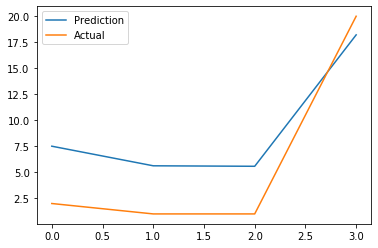

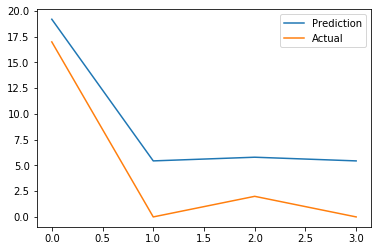

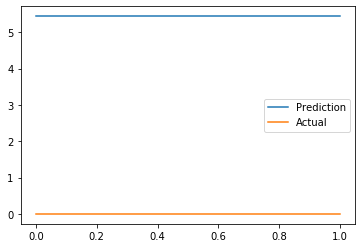

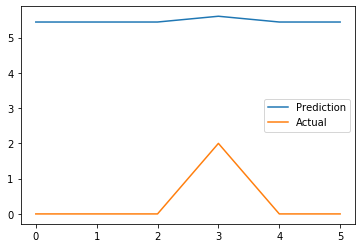

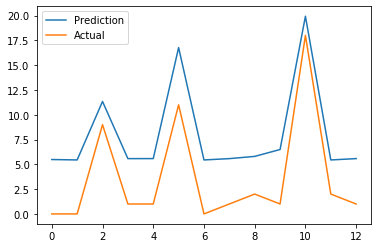

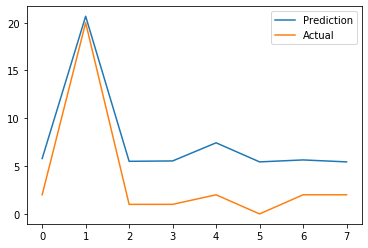

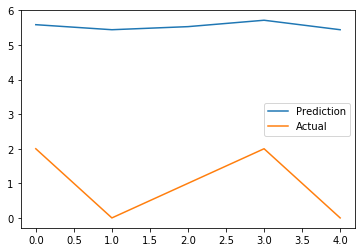

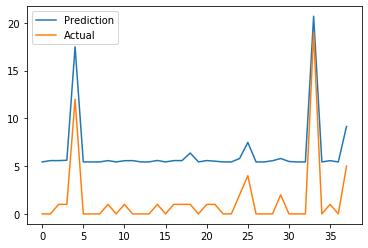

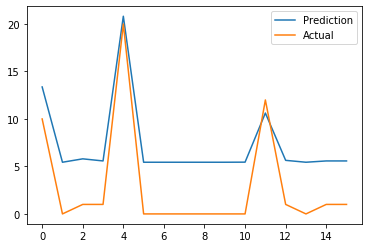

In [25]:
from numpy import asarray


score = model.evaluate(asarray(validation_x),asarray(validation_y), verbose=1)
print('Test loss:', score[0])

print('Test accuracy:', score[1])

 

trainPredict = model.predict(train_x,verbose=1)

testPredict = model.predict(validation_x,verbose=1)

trainPredict = scaler.inverse_transform(trainPredict)

trainY = scaler.inverse_transform([train_y])

testPredict = scaler.inverse_transform(testPredict)

testY = scaler.inverse_transform([validation_y])

 

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print('Test Score: %.2f RMSE' % (testScore))



# predicting the density value for various sequence of 
# density values from the test set

compare(testPredict,testY.transpose(),10,10.3)

compare(testPredict,testY.transpose(),18,18.3)

compare(testPredict,testY.transpose(),30,30.2)

compare(testPredict,testY.transpose(),42,42.5)

compare(testPredict,testY.transpose(),53,54)
compare(testPredict,testY.transpose(),60.7,61.3)

compare(testPredict,testY.transpose(),70.9,71.3)

compare(testPredict,testY.transpose(),80,83)

compare(testPredict,testY.transpose(),90,91.3)